# PixelCNN: Introduction and Tutorial

This notebook introduces PixelCNN step by step. Goal: a **physically and mathematically
accurate** explanation **and** a runnable reference implementation.

**Learning goals**
- Why autoregressive models provide exact likelihoods
- How masked convolutions enforce causality in images
- How training (negative log-likelihood) and sampling work
- Physical context: relation to entropy and statistical mechanics

**Runtime note**: The training cells are intentionally small. For better samples later,
use more epochs or a larger model.



## 1. Setup

We use PyTorch for building Neural Networks and train on MNIST (28x28 grayscale) a database with handwritten digits.

Seed is used for reproducibility and to make the results comparable in the end.

In [ ]:
# Imports and reproducibility
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device



## 2. Theory: From Regression to Autoregression

### What is regression?
Regression refers to learning a functional relationship between inputs and outputs.
Given observed inputs, the model predicts a numeric output value.

### Simple physics example (Hooke’s law)
Consider a spring. The extension $x$ (in meters) determines the force $F$ (in newtons)
via a physical law:
$$
F = kx
$$

In many machine learning settings, the exact form of this relation is unknown.
Instead, a model learns an approximation
$$
F = f(x)
$$
from measured data.

### Probabilistic perspective
In realistic experiments, measurements are noisy due to thermal fluctuations,
instrumental errors, or unresolved degrees of freedom.
A more faithful description therefore models a *distribution*:
$$
p(F \mid x)
$$
rather than a single deterministic value.


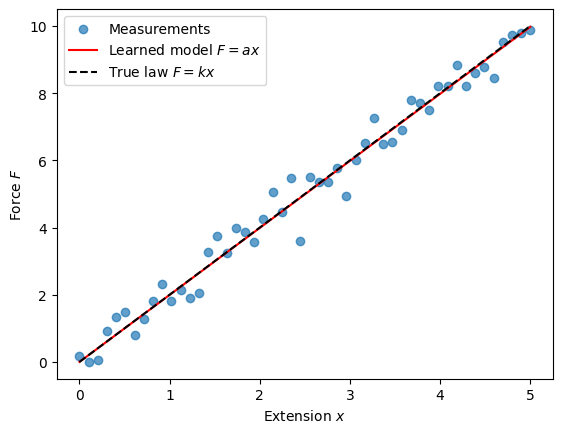

True spring constant k = 2.0
Learned parameter a ≈ 1.99


In [14]:
#Ground-truth physical law (unknown to the model)
k_true = 2.0

# Generate noisy measurements
x = np.linspace(0, 5, 50)
noise = 0.5 * np.random.randn(len(x))
F = k_true * x + noise

# Simple linear regression: F ≈ a x
a_hat = np.sum(x * F) / np.sum(x**2)
F_pred = a_hat * x

# Plot
plt.scatter(x, F, label="Measurements", alpha=0.7)
plt.plot(x, F_pred, color="red", label="Learned model $F = a x$")
plt.plot(x, k_true * x, color="black", linestyle="--", label="True law $F = kx$")
plt.xlabel("Extension $x$")
plt.ylabel("Force $F$")
plt.legend()
plt.show()

print(f"True spring constant k = {k_true}")
print(f"Learned parameter a ≈ {a_hat:.2f}")


### From regression to autoregression
So far, the output consisted of a single variable.
In many physical systems, however, the object of interest is a *configuration*
$$
x = (x_1, x_2, \dots, x_N)
$$
such as spins on a lattice or discretized field values.

Instead of predicting all components at once, we can model their joint distribution
by factorizing it using the chain rule:
$$
p(x_1, x_2, \dots, x_N)
=
\prod_{i=1}^{N} p(x_i \mid x_{<i})
$$

This factorization is exact and turns density modeling into a sequence of
conditional predictions.
Autoregressive models, such as PixelCNN, implement this idea in practice.

In [ ]:
# Intuitive visualization: regression vs autoregression
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# Regression: one output from fixed inputs
ax[0].set_title('Regression')
ax[0].scatter([0.2, 0.4, 0.6], [0.7, 0.5, 0.6], s=80)
ax[0].scatter([0.85], [0.55], s=120, marker='*')
ax[0].annotate('inputs', (0.2, 0.7))
ax[0].annotate('output', (0.85, 0.55))
ax[0].axis('off')

# Autoregression: predict x_i from previous x_<i
ax[1].set_title('Autoregression')
xs = np.linspace(0.1, 0.9, 6)
ys = np.full_like(xs, 0.5)
ax[1].scatter(xs[:-1], ys[:-1], s=80)
ax[1].scatter(xs[-1], ys[-1], s=120, marker='*')
for i in range(len(xs)-1):
    ax[1].arrow(xs[i], ys[i], xs[i+1]-xs[i]-0.03, 0, head_width=0.02, head_length=0.02, length_includes_head=True)
ax[1].annotate('past', (0.12, 0.6))
ax[1].annotate('next', (0.83, 0.6))
ax[1].axis('off')

plt.tight_layout()



## 3. PixelCNN Idea: Masked Convolutions

A standard convolution uses neighbors in all directions. That would allow the model
to see **future** pixels when predicting $x_i$. PixelCNN prevents this via **masked
convolutions**:

- **Mask A**: for the first layer (the current pixel itself is not allowed)
- **Mask B**: for later layers (current pixel allowed, but no future pixels)

This preserves autoregressive causality. The masks ensure that when predicting pixel $i$, 
the model can only use information from pixels $1, ..., i-1$, not from future pixels.


In [ ]:
# Visualize Mask A/B
def make_mask(kernel_size, mask_type):
    k = kernel_size
    mask = np.ones((k, k), dtype=np.float32)
    center = k // 2
    for i in range(k):
        for j in range(k):
            if i > center or (i == center and j > center):
                mask[i, j] = 0.0
    if mask_type == 'A':
        mask[center, center] = 0.0
    return mask

maskA = make_mask(5, 'A')
maskB = make_mask(5, 'B')

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(maskA, cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Mask A')
ax[0].axis('off')
ax[1].imshow(maskB, cmap='gray', vmin=0, vmax=1)
ax[1].set_title('Mask B')
ax[1].axis('off')
plt.tight_layout()



## 4. Implementation: MaskedConv2d and PixelCNN
We build a simple PixelCNN variant (no gating/ResNet) that shows the idea correctly.



In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert mask_type in ('A', 'B')
        self.mask_type = mask_type
        self.register_buffer('mask', torch.ones_like(self.weight))
        self._create_mask()

    def _create_mask(self):
        kH, kW = self.kernel_size
        center_h = kH // 2
        center_w = kW // 2
        self.mask[:, :, center_h+1:, :] = 0
        self.mask[:, :, center_h, center_w+1:] = 0
        if self.mask_type == 'A':
            self.mask[:, :, center_h, center_w] = 0

    def forward(self, x):
        # Enforce causality via mask without in-place weight edits
        return F.conv2d(
            x,
            self.weight * self.mask,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )



In [ ]:
class SimplePixelCNN(nn.Module):
    def __init__(self, in_channels=1, n_filters=64, n_layers=7, n_bins=16):
        super().__init__()
        layers = []
        # First layer: Mask A
        layers.append(MaskedConv2d('A', in_channels, n_filters, kernel_size=7, padding=3))
        layers.append(nn.ReLU())
        # Middle layers: Mask B
        for _ in range(n_layers - 2):
            layers.append(MaskedConv2d('B', n_filters, n_filters, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
        # Output: n_bins logits per pixel
        layers.append(MaskedConv2d('B', n_filters, n_bins, kernel_size=1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Output: [B, n_bins, H, W]
        return self.net(x)



## 5. Data: MNIST and Quantization
PixelCNN models **discrete** values. We quantize grayscale values into `n_bins`
classes (e.g., 16).



In [ ]:
# Parameters
n_bins = 16
batch_size = 64

# Load MNIST
transform = transforms.ToTensor()
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Use a subset for faster training
train_subset = Subset(train_ds, list(range(0, 5000)))
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

def quantize(x, n_bins):
    # x in [0,1] -> integer in [0, n_bins-1]
    x = torch.clamp(x, 0, 1)
    return (x * (n_bins - 1)).round().long()



## 6. Training
We optimize the negative log-likelihood, which for discrete pixels is just
cross-entropy.



In [9]:
model = SimplePixelCNN(in_channels=1, n_filters=64, n_layers=7, n_bins=n_bins).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for x, _ in loader:
        x = x.to(device)
        xq = quantize(x, n_bins)  # [B,1,H,W] int
        logits = model(x)        # [B,n_bins,H,W]
        loss = F.cross_entropy(logits, xq.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

epochs = 2  # small for demo
for epoch in range(1, epochs + 1):
    loss = train_epoch(model, train_loader)
    print('Epoch {}: loss = {:.4f}'.format(epoch, loss))



Epoch 1: loss = 1.1606


KeyboardInterrupt: 

## 7. Sampling (Generative Model)
During sampling we build an image pixel by pixel. For each pixel we compute
\(p(x_i \mid x_{<i})\) and draw a sample from that distribution.



In [ ]:
@torch.no_grad()
def sample(model, n_samples=16, shape=(1, 28, 28), n_bins=16):
    model.eval()
    C, H, W = shape
    x = torch.zeros((n_samples, C, H, W), device=device)
    for i in range(H):
        for j in range(W):
            logits = model(x)
            probs = F.softmax(logits[:, :, i, j], dim=1)
            sample_ij = torch.multinomial(probs, num_samples=1)
            # Rescale back to [0,1]
            x[:, :, i, j] = sample_ij.float() / (n_bins - 1)
    return x

samples = sample(model, n_samples=16, shape=(1, 28, 28), n_bins=n_bins)
samples = samples.cpu().numpy()

fig, ax = plt.subplots(4, 4, figsize=(6, 6))
for i in range(16):
    ax[i//4, i%4].imshow(samples[i, 0], cmap='gray')
    ax[i//4, i%4].axis('off')
plt.tight_layout()



## 8. Physical Context
PixelCNN can be viewed as a probabilistic model on a lattice. In statistical mechanics,
configurations \(x\) are often described by a Boltzmann distribution
\(p(x) \propto \exp(-E(x)/T)\). The main difficulty there is the **partition function**
(normalization), which is usually hard to compute.

In the autoregressive approach, normalization is trivial because \(p(x)\) is explicitly
constructed as a product of conditionals. This implies:
- Exact log-likelihood (no approximation of the normalization)
- Exact model entropy via the NLL

Therefore PixelCNN is physically interesting when you need **exact** probabilities on
lattice configurations, e.g., for classical spin models or as a comparison to
energy-based models.



## 9. Outlook and Extensions
- **Gated PixelCNN**: better modeling via gating and ResNet-style blocks
- **Conditional PixelCNN**: conditioning on labels or other fields
- **PixelCNN++**: logistic mixtures for continuous values

If you want, we can implement one of these variants next or adapt the model to a
physical lattice dataset.



## 10. Exercises (optional)
1. Increase `n_bins` and observe sample quality.
2. Train for more epochs and compare log-likelihood.
3. Implement residual blocks or Gated PixelCNN.
4. Test the model on a physical spin lattice.

